In [2]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy
import observations.dimensions.one.sampling as observe
import matplotlib.pyplot as plt

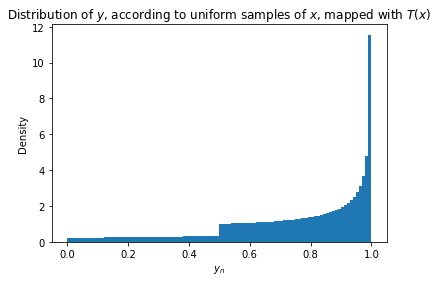

In [4]:
plt.hist(numpy.transpose(observe.sample(0))[0], bins = 100, density = True)
plt.title("Distribution of $y$, according to uniform samples of $x$, mapped with $T(x)$")
plt.xlabel("$y_n$")
plt.ylabel("Density")
plt.show()

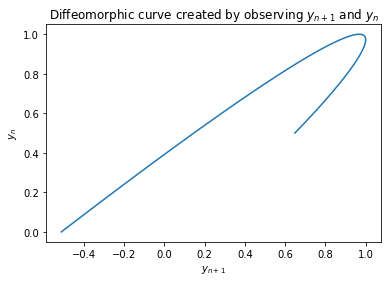

In [5]:
ys = observe.sample(1)

#plt.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], s = 0.5)
plt.plot(numpy.transpose(ys)[1], numpy.transpose(ys)[0])
plt.title("Diffeomorphic curve created by observing $y_{n+1}$ and $y_{n}$")
plt.xlabel('$y_{n+1}$')
plt.ylabel('$y_{n}$')
plt.show()

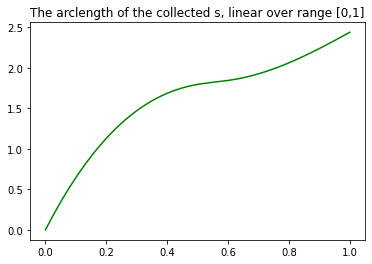

[[0.00000000e+00 1.46184814e-04]
 [1.46184814e-04 2.92362512e-04]
 [2.92362512e-04 4.38533094e-04]
 ...
 [2.43694814e+00 2.43698972e+00]
 [2.43698972e+00 2.43703131e+00]
 [2.43703131e+00 2.43707290e+00]]
[7.30924069 7.3088849  7.30852912 ... 2.07925195 2.0792686  2.07928524]


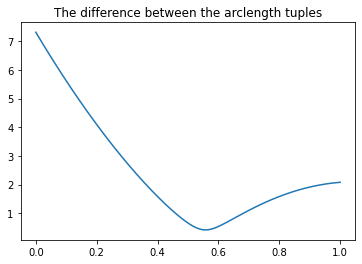

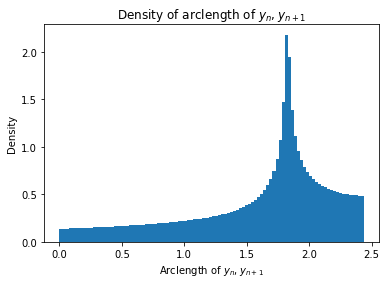

In [56]:
from observations.utils import arclen, lags

alen = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])
plt.title("The arclength of the collected s, linear over range [0,1]")
plt.plot(numpy.linspace(0, 1, observe.samplesize)[1:], alen, label = "$i = 1$, $y_{n}, y_{n+1}$", color = "green")
plt.show()

training_tuples = list(zip(*lags(arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]]), 1)))

dt = 1 / observe.samplesize

real_difference = [abs(t0 - t1) / dt for t0, t1 in training_tuples]
print(numpy.array(training_tuples))
print(numpy.array(real_difference))

plt.title("The difference between the arclength tuples") # TODO it  is not log scaled as of now
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference)
plt.show()

s = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])
plt.title("Density of arclength of $y_{n}, y_{n+1}$")
plt.hist(s, bins=100, density=True)
plt.xlabel("Arclength of $y_{n}, y_{n+1}$")
plt.ylabel("Density")
plt.show()

[Epoch:   1] training loss: 0.000031248  validation loss: 0.000105800
[Epoch:   2] training loss: 0.000026751  validation loss: 0.000105123
[Epoch:   3] training loss: 0.000026506  validation loss: 0.000103860
[Epoch:   4] training loss: 0.000026148  validation loss: 0.000101952
[Epoch:   5] training loss: 0.000025439  validation loss: 0.000098155
[Epoch:   6] training loss: 0.000024114  validation loss: 0.000090938
[Epoch:   7] training loss: 0.000021674  validation loss: 0.000078965
[Epoch:   8] training loss: 0.000018057  validation loss: 0.000062519
[Epoch:   9] training loss: 0.000013386  validation loss: 0.000042558
[Epoch:  10] training loss: 0.000009699  validation loss: 0.000036715
[Epoch:  11] training loss: 0.000009181  validation loss: 0.000035779
[Epoch:  12] training loss: 0.000008960  validation loss: 0.000034810
[Epoch:  13] training loss: 0.000008701  validation loss: 0.000033725
[Epoch:  14] training loss: 0.000008435  validation loss: 0.000032754
[Epoch:  15] trainin

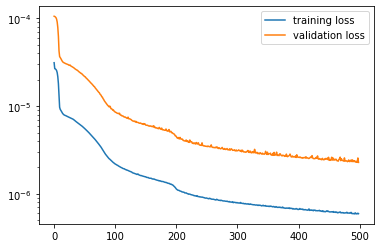

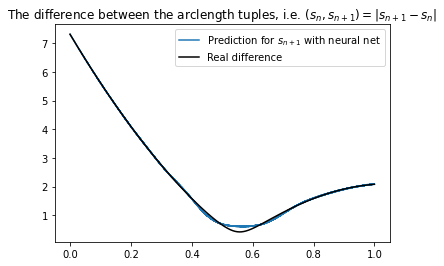

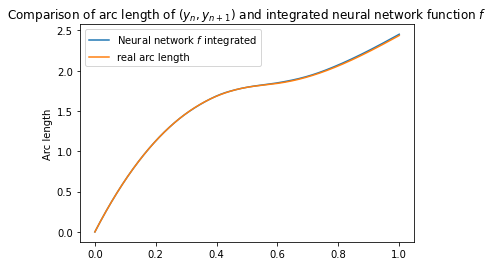

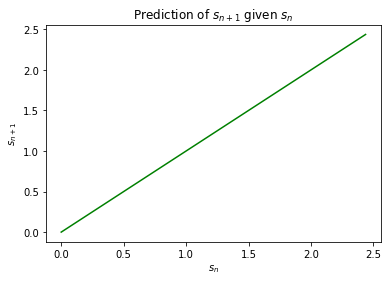

input.weight tensor([[ -4.8301,  -0.5610],
        [-14.8223,   0.3164],
        [ -5.4274,  -0.0979],
        [ -4.3138,  -0.2350],
        [-17.2348,   0.1130],
        [  6.8417,  -0.4327],
        [-18.9123,   0.2559],
        [-19.2104,  -0.3009],
        [ -6.3298,   0.6559],
        [  4.6874,  -0.5195],
        [  5.9172,   0.5208],
        [ 11.1196,   0.2424],
        [ -7.8503,   0.3609],
        [  5.0490,   0.4806],
        [ -6.2910,  -0.3604],
        [ -4.4386,  -0.5846],
        [ -4.5560,   0.1338],
        [  4.5710,   0.2907],
        [  3.9770,  -0.6569],
        [ -3.7634,   0.3239]])
input.bias tensor([  3.0179,  26.1219,   2.3190,  -1.9828,  30.4199, -14.0244,  33.5380,
         35.9042,   5.6510,  -0.2436,  -5.2749, -16.8953,  11.4451,  -1.3583,
          7.1395,  -1.6132,   8.8776,  -2.0794,   0.7997,  -1.7925])
output.weight tensor([[ 0.2107,  0.7676,  1.3505,  0.3356, -0.7835,  1.1485, -2.5461,  8.0748,
          0.0920, 10.0348, -0.5724,  4.7734, -3.2280, -

In [78]:
import dynamics.nets as nets
import dynamics.utils
import torch
import torch.nn as nn

model = nets.RK4N(input_size=1, num_param=1, hidden_size=20, h=dt, num_hidden_layers=2)

def f(t, y):
    return model.one_step(torch.FloatTensor([y])).detach().numpy()[0]

def s_n1(s_n):
    return model(torch.tensor([[s_n]]).float()).item()

def s_n1_tensor(s_n):
    return model(s_n.float())

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
train_loader, val_loader = dynamics.utils.training_validator_splitter(training_tuples, bs=300)

# Losses
train_losses = []
val_losses = []

for epoch in range(1, 500):  # loop over the dataset multiple times
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = torch.unsqueeze(inputs, 1).float()
        labels = torch.unsqueeze(labels, 1).float()

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # For statistics
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs = torch.unsqueeze(inputs, 1).float()
            labels = torch.unsqueeze(labels, 1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print('[Epoch: %3d] training loss: %.9f  validation loss: %.9f' %
            (epoch, train_loss,val_loss))

    model.save("full_one_dimensional/non_normalized/" + str(epoch) + ".model")

plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.yscale("log")
plt.legend()
plt.show()



###############################

fitted_values = s_n1_tensor(torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples)[0]), 1))
training_tuples_fitted = torch.cat((torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples)[0]), 1), fitted_values), 1).detach().numpy()

difference = numpy.abs(training_tuples_fitted[:, 0] - training_tuples_fitted[:, 1]) / dt

plt.title("The difference between the arclength tuples, i.e. $(s_n, s_{n+1}) = | s_{n+1} - s_{n}|$")
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], difference, label="Prediction for $s_{n+1}$ with neural net")
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference, label="Real difference" ,color='black')
#TODO: readd
plt.legend()
plt.show()

from scipy.integrate import solve_ivp

t_eval = numpy.linspace(0, observe.samplesize * dt, observe.samplesize)
sol = solve_ivp(f, [0, observe.samplesize * dt], [0], t_eval=t_eval)

plt.title("Comparison of arc length of $(y_n, y_{n+1})$ and integrated neural network function $f$")
plt.ylabel("Arc length")
plt.plot(t_eval, sol.y[0], label="Neural network $f$ integrated")
plt.plot(t_eval[1:], alen, label="real arc length")
plt.legend()
plt.show()

plt.title("Prediction of $s_{n+1}$ given $s_n$")
plt.plot(numpy.linspace(0, s[-1], 1000), [s_n1(x) for x in numpy.linspace(0, s[-1], 1000)], label = "$i = 1$, $y_{n}, y_{n+1}$", color = "green")
plt.xlabel("$s_{n}$")
plt.ylabel("$s_{n+1}$")
plt.show()

for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

###############################




In [74]:
model = torch.load("full_one_dimensional/non_normalized/" + str(99) + ".model")
model.eval()

t_eval = numpy.linspace(0, observe.samplesize * dt, observe.samplesize)
sol = solve_ivp(f, [0, observe.samplesize * dt], [0], t_eval=t_eval)

acc = 0
accumulated_points = []
for i in range(observe.samplesize):
    accumulated_points.append(acc)
    acc = s_n1(acc)
    if i % 5000 == 0:
        print(i / observe.samplesize)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


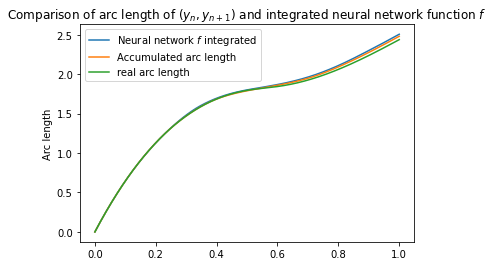

In [75]:
plt.title("Comparison of arc length of $(y_n, y_{n+1})$ and integrated neural network function $f$")
plt.ylabel("Arc length")
plt.plot(t_eval, sol.y[0], label="Neural network $f$ integrated")
plt.plot(t_eval, accumulated_points, label="Accumulated arc length")
plt.plot(t_eval[1:], alen, label="real arc length")
plt.legend()
plt.show()